In [1727]:
from igraph import *
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
import numpy as np
import re
import timeit

import igraph
import networkx as nx
import pandas as pd
import math


In [1728]:
def PreserveLargestConnectedGraph(G):
    Max = set()
    for S in list(nx.connected_components(G)):
        if len(S) > len(Max):
            G.remove_nodes_from(Max)
            Max = S
        else:
            G.remove_nodes_from(S)
    return G

In [1729]:
raw_data = pd.read_csv('../data/Contact-diaries-network_data_2013.csv',names=['userID', 'friendID','weight'])

In [1730]:
print(raw_data)

     userID  friendID  weight
0         3        28       2
1         3       106       1
2         3       147       4
3         3       177       1
4         3       295       4
..      ...       ...     ...
497    1828      1237       1
498    1828      1295       1
499    1828      1412       1
500    1828      1423       2
501    1828      1594       4

[502 rows x 3 columns]


In [1731]:
len(pd.unique(raw_data['userID']))

119

In [1732]:
G = nx.Graph()
subset =raw_data#[raw_data['weight']==1]
data = [(userID, friendID) for userID, friendID in zip(subset['userID'], subset['friendID'])]
G.add_edges_from(data)

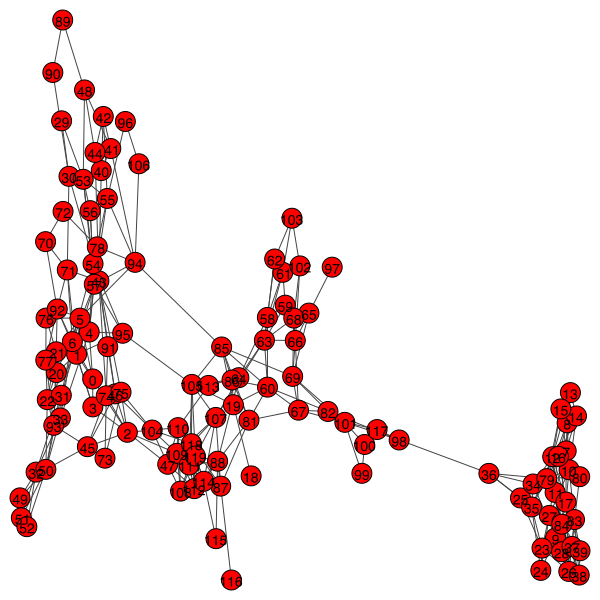

In [1733]:
# original graph
g= igraph.Graph.from_networkx(G)
igraph.plot(g,vertex_label=range(g.vcount()))

In [1734]:
# add weights to the graph
for i in range(g.ecount()):
    #print(i)
    if len(raw_data.loc[(raw_data['userID']==g.vs[g.es[i].source]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].target]['_nx_name'])]['weight'].values)>0:
        g.es[i]['weight'] = raw_data.loc[(raw_data['userID']==g.vs[g.es[i].source]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].target]['_nx_name'])]['weight'].values[0]
    elif len(raw_data.loc[(raw_data['userID']==g.vs[g.es[i].target]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].source]['_nx_name'])]['weight'].values)>0:
        g.es[i]['weight'] = raw_data.loc[(raw_data['userID']==g.vs[g.es[i].target]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].source]['_nx_name'])]['weight'].values[0]

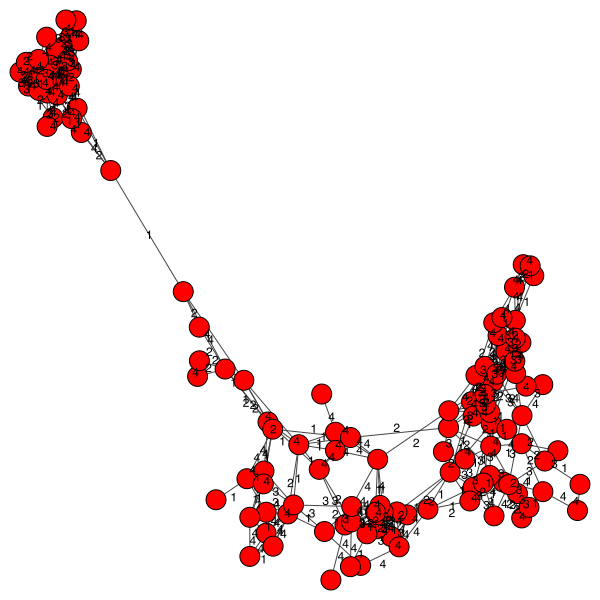

In [1735]:
igraph.plot(g,edge_label=g.es['weight'])

In [1736]:
g.vcount()

120

In [1737]:
g.ecount()

348

In [1738]:
import random

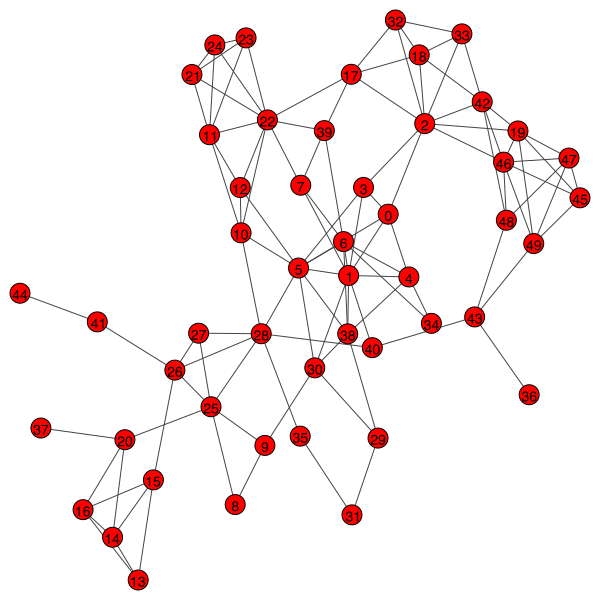

In [1739]:
G1 = nx.Graph()
while True:
    G1 = nx.subgraph(G,random.sample(list(G.nodes),90))
    G1 = nx.Graph(G1)
    G1 = PreserveLargestConnectedGraph(G1)
    if 40 <= nx.number_of_nodes(G1) <= 50:
        break
g1 = igraph.Graph.from_networkx(G1)
igraph.plot(g1,vertex_label=range(g1.vcount()))

In [1740]:
g1.vcount()

50

In [1741]:
g1.ecount()

112

In [1742]:
print(G1)

Graph with 50 nodes and 112 edges


In [1743]:
#define the model for Node Location Design

In [1744]:
N=g1.vcount()

In [1745]:
N

50

In [1746]:
# constants
# cost of connecting area i to possible location j
# pre-calculated value, by different topology
cost_connect = g1.distances()
cost_open = np.ones(N)*10

In [1747]:
for i in range(N):
    for j in range(N):
        if cost_connect[i][j]>1:
            cost_connect[i][j] = 999#math.inf
        if cost_connect[i][j] ==1:
            user_id = g1.vs[i]['_nx_name']
            friend_id = g1.vs[j]['_nx_name']
            #print(i,j,user_id,friend_id)
            if len(raw_data.loc[(raw_data['userID']==user_id)&(raw_data['friendID']==friend_id)])>0:
                cost_connect[i][j] = raw_data.loc[(raw_data['userID']==user_id)&(raw_data['friendID']==friend_id)]['weight'].values[0]
            elif len(raw_data.loc[(raw_data['userID']==friend_id)&(raw_data['friendID']==user_id)])>0:
                cost_connect[i][j] =raw_data.loc[(raw_data['userID']==friend_id)&(raw_data['friendID']==user_id)]['weight'].values[0]

In [1748]:
count=0
for i in range(N):
    for j in range(N):
        if 999 > cost_connect[i][j] > 1:
            #print(cost_connect[i][j])
            count+=1

In [1749]:
count

181

In [1750]:
# # Creates a list of tuples containing all the possible routes for nodes
# Routes = [(i, j) for i in range(N) for j in range(N)]

In [1751]:
# Define the model
model = LpProblem(name="node-location", sense=LpMinimize)
# Define the decision variables
u = {(i,j): LpVariable(name=f"u{(i,j)}", cat='Binary') for i in range(N) for j in range(N)}
# define decay index
epsilon = 2
# Define the node type variables
S = {i: LpVariable(name=f"S{i}", cat='Binary')for i in range(N)}
a = {i: LpVariable(name=f"a{i}", cat='Binary')for i in range(N)}
b = {i: LpVariable(name=f"b{i}", cat='Binary')for i in range(N)}
c = {i: LpVariable(name=f"c{i}", cat='Binary')for i in range(N)}
#Define the connect access variables
Sa = {(i,j): LpVariable(name=f"Sa{i,j}", cat='Binary')for i in range(N) for j in range(N)}
ab = {(i,j): LpVariable(name=f"ab{i,j}", cat='Binary')for i in range(N) for j in range(N)}
bc = {(i,j): LpVariable(name=f"bc{i,j}", cat='Binary')for i in range(N) for j in range(N)}


In [1752]:
u[0,0]

u(0,_0)

In [1753]:
type(cost_connect)

list

In [1754]:
#add objective function first
model += (
    lpSum(Sa[i,j]*cost_connect[i][j] +
          epsilon*ab[i,j]*cost_connect[i][j] +
          epsilon*epsilon*bc[i,j]*cost_connect[i][j] for i in range(N) for j in range(N))
    +lpSum(cost_open[i]*S[i] for i in range(N)),
    'Sum of open and connect cost',
)

In [1755]:
#Add constraints
for j in range(N):
    model += (
        lpSum(u[i,j] for i in range(N)) == 1-S[j],
        f"connected constraints_{j}",
    )

for i in range(N):
    for j in range(N):
            model += (
                u[i,j] <= Sa[i,j]+ab[i,j]+bc[i,j],
                f'no connection across different casade or node constraint_{i,j}',
            )
for i in range(N):
    for j in range(N):
            model += (
                Sa[i,j] <= S[i],
                f'S a first connection constraint_{i,j}',
            )

for i in range(N):
    for j in range(N):
            model += (
                Sa[i,j] <= a[j],
                f'S a second connection constraint_{i,j}',
            )
            
for i in range(N):
    for j in range(N):
            model += (
                ab[i,j] <= a[i],
                f'a b first connection constraint_{i,j}',
            )
for i in range(N):
    for j in range(N):
            model += (
                ab[i,j] <= b[j],
                f'a b second connection constraint_{i,j}',
            )
            
for i in range(N):
    for j in range(N):
            model += (
                bc[i,j] <= b[i],
                f'b c first connection constraint_{i,j}',
            )
for i in range(N):
    for j in range(N):
            model += (
                bc[i,j] <= c[j],
                f'b c second connection constraint_{i,j}',
            )
            
            
for i in range(N):
     model += (
        u[i,i] == 0,
        f"node can not connect to it self constraints_{i}",
    )
for i in range(N):
     model += (
        lpSum(u[i,j] for j in range(N)) <=(S[i]+a[i]+b[i])*N,
        f"node S capacity constraints_{i}",
    )
# for i in range(N):
#      model += (
#         lpSum(u[i,j] for j in range(N)) <=(a[i])*N,
#         f"node a capacity constraints_{i}",
#     )
for i in range(N):
     model += (
        S[i]+a[i]+b[i]+c[i] == 1,
        f"node type constraints_{i}",
    )
# model += (
#         lpSum(S[i] for i in range(N)) >=1,
#         f"make sure at lease one Source node constraints_{i}",
# )

In [1756]:
# Solve the optimization problem
start = timeit.default_timer()
status = model.solve()
stop = timeit.default_timer()
print('Time: ', stop - start)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/54/b46qlvhj6s50qkyccs51rmk80000gn/T/5faf10235790428f90cab696010bc591-pulp.lp
 -o /var/folders/54/b46qlvhj6s50qkyccs51rmk80000gn/T/5faf10235790428f90cab696010bc591-pulp.sol
Reading problem data from '/var/folders/54/b46qlvhj6s50qkyccs51rmk80000gn/T/5faf10235790428f90cab696010bc591-pulp.lp'...
17700 rows, 10200 columns, 45450 non-zeros
10200 integer variables, all of which are binary
33044 lines were read
GLPK Integer Optimizer 5.0
17700 rows, 10200 columns, 45450 non-zeros
10200 integer variables, all of which are binary
Preprocessing...
2450 hidden covering inequaliti(es) were detected
150 constraint coefficient(s) were reduced
17600 rows, 10150 columns, 45100 non-zeros
10150 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.900e+01  ratio =  4.900e+01
GM: min|aij| =  3.780e-01  max|aij| =  2.646e+00  ratio =  7.000e+00
EQ: min|aij| =  1.429e-01 

In [1757]:
# Get the results
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

status: 1, Optimal
objective: 179.0


In [1758]:
#print connection
selected_edge_set = set()
for var in u.values():
    if var.value() == 1:
        print(f"{var.name}: {var.value()}")
        selected_edge_set.add((int(re.findall(r'\d+',var.name)[0]),int(re.findall(r'\d+',var.name)[1])))
        #print(re.findall(r'\d+',var.name))

u(2,_0): 1
u(2,_3): 1
u(2,_19): 1
u(2,_32): 1
u(2,_33): 1
u(2,_42): 1
u(2,_46): 1
u(4,_1): 1
u(5,_30): 1
u(6,_4): 1
u(6,_5): 1
u(6,_7): 1
u(6,_34): 1
u(6,_38): 1
u(6,_39): 1
u(14,_13): 1
u(19,_47): 1
u(20,_14): 1
u(20,_16): 1
u(20,_37): 1
u(21,_11): 1
u(21,_22): 1
u(21,_23): 1
u(21,_24): 1
u(22,_10): 1
u(22,_12): 1
u(22,_17): 1
u(25,_8): 1
u(25,_9): 1
u(26,_15): 1
u(26,_25): 1
u(26,_28): 1
u(26,_41): 1
u(28,_27): 1
u(31,_29): 1
u(31,_35): 1
u(41,_44): 1
u(42,_18): 1
u(43,_36): 1
u(43,_40): 1
u(43,_48): 1
u(43,_49): 1
u(49,_45): 1


In [1759]:
selected_edge_set

{(2, 0),
 (2, 3),
 (2, 19),
 (2, 32),
 (2, 33),
 (2, 42),
 (2, 46),
 (4, 1),
 (5, 30),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 34),
 (6, 38),
 (6, 39),
 (14, 13),
 (19, 47),
 (20, 14),
 (20, 16),
 (20, 37),
 (21, 11),
 (21, 22),
 (21, 23),
 (21, 24),
 (22, 10),
 (22, 12),
 (22, 17),
 (25, 8),
 (25, 9),
 (26, 15),
 (26, 25),
 (26, 28),
 (26, 41),
 (28, 27),
 (31, 29),
 (31, 35),
 (41, 44),
 (42, 18),
 (43, 36),
 (43, 40),
 (43, 48),
 (43, 49),
 (49, 45)}

In [1760]:
b[1]

b1

In [1761]:
#print open node:
selected_v_set = set()
for var in S.values():
    if var.value() == 1:
        print(f"{var.name}: {var.value()}")
        selected_v_set.add(int(re.findall(r'\d+',var.name)[0]))

S2: 1
S6: 1
S20: 1
S21: 1
S26: 1
S31: 1
S43: 1


In [1762]:
for i in range(g1.vcount()):
    print(i, g1.neighbors(i))


0 [1, 2, 3, 4, 5]
1 [0, 3, 4, 5, 6, 7, 30, 38, 40]
2 [0, 3, 17, 18, 19, 32, 33, 42, 46]
3 [0, 1, 2, 5]
4 [0, 1, 6, 34, 38]
5 [0, 1, 3, 6, 10, 12, 28, 30, 38]
6 [1, 4, 5, 7, 34, 38, 39]
7 [1, 6, 22, 39]
8 [9, 25]
9 [8, 25, 30]
10 [5, 11, 12, 22, 28]
11 [10, 12, 21, 22, 23, 24]
12 [5, 10, 11, 22]
13 [14, 15, 16]
14 [13, 15, 16, 20]
15 [13, 14, 16, 26]
16 [13, 14, 15, 20]
17 [2, 18, 22, 32, 39]
18 [2, 17, 32, 33, 42]
19 [2, 42, 45, 46, 47, 49]
20 [14, 16, 25, 37]
21 [11, 22, 23, 24]
22 [7, 10, 11, 12, 17, 21, 23, 24, 39]
23 [11, 21, 22, 24]
24 [11, 21, 22, 23]
25 [8, 9, 20, 26, 27, 28]
26 [15, 25, 27, 28, 41]
27 [25, 26, 28]
28 [5, 10, 25, 26, 27, 35, 40]
29 [30, 31, 38]
30 [1, 5, 9, 29, 38]
31 [29, 35]
32 [2, 17, 18, 33]
33 [2, 18, 32, 42]
34 [4, 6]
35 [28, 31]
36 [43]
37 [20]
38 [1, 4, 5, 6, 29, 30]
39 [6, 7, 17, 22]
40 [1, 28, 43]
41 [26, 44]
42 [2, 18, 19, 33, 46, 48]
43 [36, 40, 48, 49]
44 [41]
45 [19, 46, 47, 49]
46 [2, 19, 42, 45, 47, 48, 49]
47 [19, 45, 46, 48, 49]
48 [42, 43, 46,

In [1763]:
selected_v_set

{2, 6, 20, 21, 26, 31, 43}

In [1764]:
selected_v_neighbour_number = {}
for item in selected_v_set:
    selected_v_neighbour_number[item] = 0
for item in selected_edge_set:
    print(item[0],item[1])
    if item[0] in selected_v_neighbour_number:
        selected_v_neighbour_number[item[0]]+=1

2 33
20 14
43 40
2 42
43 49
21 22
22 17
6 39
14 13
31 29
31 35
28 27
6 5
43 36
20 16
2 32
22 10
21 24
43 48
26 41
6 38
20 37
25 9
5 30
6 4
2 19
6 7
26 25
41 44
19 47
26 28
4 1
21 11
21 23
22 12
2 46
6 34
49 45
2 0
2 3
25 8
42 18
26 15


In [1765]:
selected_v_neighbour_number

{2: 7, 6: 6, 43: 4, 20: 3, 21: 4, 26: 4, 31: 2}

In [1766]:
#g.get_eid(item[0], item[1])

In [1767]:
color_set = ['blue','green','yellow','pink','purple','red','orange']

In [1768]:
color = dict()
count = 0
for item in selected_v_set:
    print(item,count)
    color[item]=color_set[count]
    count+=1
    count = count%len(color_set)

2 0
6 1
43 2
20 3
21 4
26 5
31 6


In [1769]:
color

{2: 'blue',
 6: 'green',
 43: 'yellow',
 20: 'pink',
 21: 'purple',
 26: 'red',
 31: 'orange'}

In [1770]:
selected_edge_set

{(2, 0),
 (2, 3),
 (2, 19),
 (2, 32),
 (2, 33),
 (2, 42),
 (2, 46),
 (4, 1),
 (5, 30),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 34),
 (6, 38),
 (6, 39),
 (14, 13),
 (19, 47),
 (20, 14),
 (20, 16),
 (20, 37),
 (21, 11),
 (21, 22),
 (21, 23),
 (21, 24),
 (22, 10),
 (22, 12),
 (22, 17),
 (25, 8),
 (25, 9),
 (26, 15),
 (26, 25),
 (26, 28),
 (26, 41),
 (28, 27),
 (31, 29),
 (31, 35),
 (41, 44),
 (42, 18),
 (43, 36),
 (43, 40),
 (43, 48),
 (43, 49),
 (49, 45)}

In [1771]:
# same information type has same color
g1.vs["color"] = "red"
g1.es["color"] = "grey"
g1.es['width'] = 0.5
g1.es['steps'] = ''
for item in selected_edge_set:
    e = g1.get_eid(item[0], item[1])
    if S[item[0]].value()==1:
        g1.vs[item[0]]["width"] = 60
        g1.vs[item[0]]['color'] = color[item[0]]
        g1.es[e]["color"] = g1.vs[item[0]]['color']
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 1
        g1.vs[item[1]]["width"] = 45
        g1.vs[item[1]]['color'] = g1.vs[item[0]]['color']
        
for item in selected_edge_set:
    e = g1.get_eid(item[0], item[1])
    if a[item[0]].value()==1:
        g1.es[e]["color"] = g1.vs[item[0]]['color']
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 2
        g1.vs[item[1]]["width"] = 30
        g1.vs[item[1]]['color'] = g1.vs[item[0]]['color']
        
for item in selected_edge_set:
    e = g1.get_eid(item[0], item[1])
    if b[item[0]].value()==1:
        g1.es[e]["color"] = g1.vs[item[0]]['color']
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 3
        g1.vs[item[1]]["width"] = 20
        g1.vs[item[1]]['color'] = g1.vs[item[0]]['color']

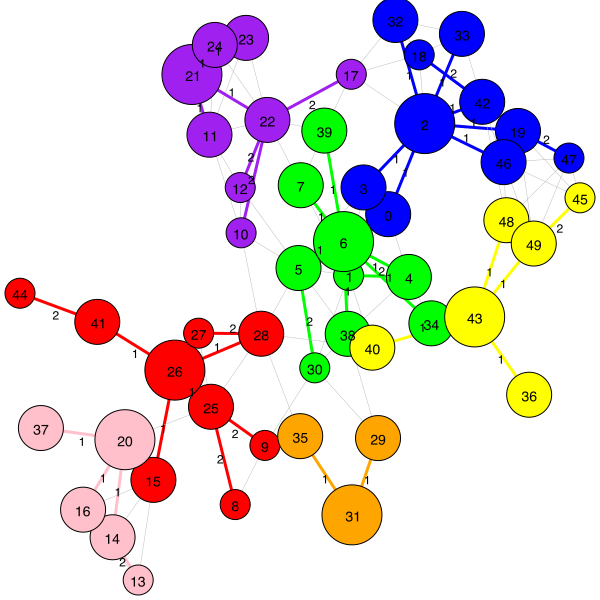

In [1772]:
igraph.plot(g1,vertex_label=range(g1.vcount()),edge_label=g1.es['steps'])

In [1773]:
# same casacade has same color
g1.vs["color"] = "red"
g1.es["color"] = "grey"
g1.es['width'] = 0.5
g1.es['steps'] = ''
for item in selected_edge_set:
    e = g1.get_eid(item[0], item[1])
    if S[item[0]].value()==1:
        g1.vs[item[0]]["width"] = 60
        g1.vs[item[0]]['color'] = color_set[0]
        g1.es[e]["color"] = color_set[0]
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 1
        g1.vs[item[1]]["width"] = 45
        g1.vs[item[1]]['color'] = color_set[1]
        
    elif a[item[0]].value()==1:
        g1.es[e]["color"] = color_set[1]
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 2
        g1.vs[item[1]]["width"] = 30
        g1.vs[item[1]]['color'] = color_set[2]
        
    elif b[item[0]].value()==1:
        g1.es[e]["color"] = color_set[2]
        g1.es[e]["width"] = 3
        g1.es[e]['steps'] = 3
        g1.vs[item[1]]["width"] = 20
        g1.vs[item[1]]['color'] = color_set[3]

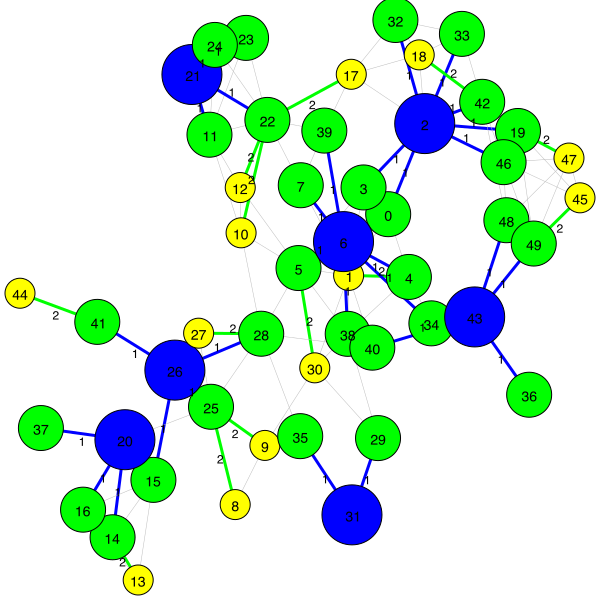

In [1774]:
igraph.plot(g1,vertex_label=range(g1.vcount()),edge_label=g1.es['steps'])

In [1775]:
for e in g1.es():
    e['weight'] = cost_connect[e.source][e.target]

In [1776]:
Nodes = [set() for i in range(4)]
Nodes

[set(), set(), set(), set()]

In [1777]:
from queue import PriorityQueue
extractNum = 3

#eigenvalue centrality
c = g1.evcent()
eigenvalue_centrality = {}
for node, centrality in enumerate(c):
    eigenvalue_centrality[node] = centrality

c = g1.pagerank()
pagerank_centrality = {}
for node, centrality in enumerate(c):
    pagerank_centrality[node] = centrality

#between centrality
c = nx.closeness_centrality(G)
closeness_centrality = {}
for node, centrality in enumerate(c):
    closeness_centrality[node] = centrality

c = nx.degree_centrality(G)
degree_centrality = {}
for node, centrality in enumerate(c):
    degree_centrality[node] = centrality


In [1778]:
def algorithm(graph, level, priority):
    Nodes = [set() for i in range(level)]
    ready = PriorityQueue()
    free = set([v.index for v in graph.vs])
    neighbors = {v.index: [] for v in graph.vs}
    for e in graph.es:
        v1 = e.source
        v2 = e.target
        neighbors[v1].append((v2,  e['weight']))
        neighbors[v2].append((v1,  e['weight']))
    edges = []

    if priority == 'EIGENVALUE':
        metric = [key for key, _ in sorted(eigenvalue_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'CLOSENESS':
        metric = [key for key, _ in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'DEGREE':
        metric = [key for key, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'PAGERANK':
        metric = [key for key, _ in sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)]
    else:
        raise Exception("No such metric")
    idx = 0
    total_cost = 0

    def getAll():
        components = set()
        for s in Nodes:
            components = components.union(s)
        return components

    #cost_open
    def add_neighbors(source, Nodes, ready):
        for neighbor, cost in neighbors[source]:
            if neighbor not in getAll():
                for i in range(level - 1):
                    if source in Nodes[i]:
                        ready.put((cost*epsilon**i, source, neighbor))
        return

    while len(getAll()) < graph.vcount():
        # set site nodes
        while idx < len(metric):

            source = metric[idx]
            if source in free: #S.union(a).union(b).union(c):
                total_cost += cost_open[source]
                Nodes[0].add(source)
                free.remove(source)
                add_neighbors(source, Nodes, ready)
                break
            else:
                idx += 1

        # extract min
        if not ready.empty():
            cost, source, neighbor = ready.get()
            if cost > cost_open[neighbor]:
                ready.put((cost, source, neighbor))
            while cost <= cost_open[neighbor]:
                if neighbor in free:

                    free.remove(neighbor)
                    edges.append((source, neighbor))

                    total_cost += cost
                    for i in range(level - 1):
                        if source in Nodes[i]:
                            Nodes[i+1].add(neighbor)
                            add_neighbors(neighbor, Nodes, ready)

                    if source in Nodes[-1]:
                        raise Exception("source node wrong")
                if ready.empty():
                    break
                cost, source, neighbor = ready.get()

        # print("S: {}, a: {}, b: {}, c: {}".format(Nodes[0], Nodes[1], Nodes[2], Nodes[3]))
    return Nodes, edges, total_cost

In [1779]:
def algorithm_with_update(graph, level, priority):
    Nodes = [set() for i in range(level)]
    ready = PriorityQueue()
    free = set([v.index for v in graph.vs])
    neighbors = {v.index: [] for v in graph.vs}
    for e in graph.es:
        v1 = e.source
        v2 = e.target
        neighbors[v1].append((v2,  e['weight']))
        neighbors[v2].append((v1,  e['weight']))
    edges = []

    if priority == 'EIGENVALUE':
        metric = [key for key, _ in sorted(eigenvalue_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'CLOSENESS':
        metric = [key for key, _ in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'DEGREE':
        metric = [key for key, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'PAGERANK':
        metric = [key for key, _ in sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)]
    else:
        raise Exception("No such metric")
    idx = 0
    total_cost = 0

    def getAll():
        components = set()
        for s in Nodes:
            components = components.union(s)
        return components

    #cost_open
    def add_neighbors(source, Nodes, ready):
        for neighbor, cost in neighbors[source]:
            if neighbor not in getAll():
                for i in range(level - 1):
                    if source in Nodes[i]:
                        ready.put((cost*epsilon**i, source, neighbor))
            else:
                if neighbor in Nodes[0]:
                    continue
                pre = [x for x, y in edges if neighbor == y]
                if len(pre) != 1:
                    raise Exception("wrong connections")
                pre_cost = graph.es[graph.get_eid(pre[0], neighbor)]['weight']
                for i in range(level - 1):
                    if pre[0] in Nodes[i]:
                        pre_cost *= epsilon**i
                valid = False
                for i in range(level):
                    if i != level - 1 and source in Nodes[i] and cost*epsilon**i < pre_cost:
                        valid = True
                        nonlocal total_cost
                        total_cost -= pre_cost
                        edges.remove((pre[0], neighbor))
                        ready.put((cost*epsilon**i, source, neighbor))
                    if neighbor in Nodes[i] and valid:
                        free.add(neighbor)
                        Nodes[i].remove(neighbor)
        return

    while len(getAll()) < graph.vcount():
        # set site nodes
        while idx < len(metric):

            source = metric[idx]
            if source in free: #S.union(a).union(b).union(c):
                total_cost += cost_open[source]
                Nodes[0].add(source)
                free.remove(source)
                add_neighbors(source, Nodes, ready)
                break
            else:
                idx += 1

        # extract min
        if not ready.empty():
            cost, source, neighbor = ready.get()
            if cost > cost_open[neighbor]:
                ready.put((cost, source, neighbor))
            while cost <= cost_open[neighbor]:
                if neighbor in free:
                    free.remove(neighbor)
                    edges.append((source, neighbor))

                    total_cost += cost
                    for i in range(level - 1):
                        if source in Nodes[i]:
                            Nodes[i+1].add(neighbor)
                            add_neighbors(neighbor, Nodes, ready)
                    if source in Nodes[-1]:
                        raise Exception("source node wrong")
                if ready.empty():
                    break
                cost, source, neighbor = ready.get()
        # print(free)
        # print(free)
        # print("S: {}, a: {}, b: {}".format(Nodes[0], Nodes[1], Nodes[2]))
    return Nodes, edges, total_cost

In [1780]:
Nodes, edges, total_cost = algorithm(g1, 4, 'EIGENVALUE')
print("cost: ", total_cost)

cost:  260.0


In [1781]:
def algorithm_with_update(graph, level, priority):
    Nodes = [set() for i in range(level)]
    ready = PriorityQueue()
    free = set([v.index for v in graph.vs])
    neighbors = {v.index: [] for v in graph.vs}
    for e in graph.es:
        v1 = e.source
        v2 = e.target
        neighbors[v1].append((v2,  e['weight']))
        neighbors[v2].append((v1,  e['weight']))
    edges = []

    if priority == 'EIGENVALUE':
        metric = [key for key, _ in sorted(eigenvalue_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'CLOSENESS':
        metric = [key for key, _ in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'DEGREE':
        metric = [key for key, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)]
    elif priority == 'PAGERANK':
        metric = [key for key, _ in sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)]
    else:
        raise Exception("No such metric")
    idx = 0
    total_cost = 0

    def getAll():
        components = set()
        for s in Nodes:
            components = components.union(s)
        return components

    #cost_open
    def add_neighbors(source, Nodes, ready):
        for neighbor, cost in neighbors[source]:
            if neighbor not in getAll():
                for i in range(level - 1):
                    if source in Nodes[i]:
                        ready.put((cost*epsilon**i, source, neighbor))
            else:
                if neighbor in Nodes[0]:
                    continue
                pre = [x for x, y in edges if neighbor == y]
                if len(pre) != 1:
                    raise Exception("wrong connections")
                pre_cost = graph.es[graph.get_eid(pre[0], neighbor)]['weight']
                for i in range(level - 1):
                    if pre[0] in Nodes[i]:
                        pre_cost *= epsilon**i
                valid = False
                for i in range(level):
                    if i != level - 1 and source in Nodes[i] and cost*epsilon**i < pre_cost:
                        valid = True
                        nonlocal total_cost
                        total_cost -= pre_cost
                        edges.remove((pre[0], neighbor))
                        ready.put((cost*epsilon**i, source, neighbor))
                    if neighbor in Nodes[i] and valid:
                        free.add(neighbor)
                        Nodes[i].remove(neighbor)
        return

    while len(getAll()) < graph.vcount():
        # set site nodes
        while idx < len(metric):

            source = metric[idx]
            if source in free: #S.union(a).union(b).union(c):
                total_cost += cost_open[source]
                Nodes[0].add(source)
                free.remove(source)
                add_neighbors(source, Nodes, ready)
                break
            else:
                idx += 1

        # extract min
        if not ready.empty():
            cost, source, neighbor = ready.get()
            if cost > cost_open[neighbor]:
                ready.put((cost, source, neighbor))
            while cost <= cost_open[neighbor]:
                if neighbor in free:
                    free.remove(neighbor)
                    edges.append((source, neighbor))

                    total_cost += cost
                    for i in range(level - 1):
                        if source in Nodes[i]:
                            Nodes[i+1].add(neighbor)
                            add_neighbors(neighbor, Nodes, ready)
                    if source in Nodes[-1]:
                        raise Exception("source node wrong")
                if ready.empty():
                    break
                cost, source, neighbor = ready.get()
        # print(free)
        # print(free)
        # print("S: {}, a: {}, b: {}".format(Nodes[0], Nodes[1], Nodes[2]))
    return Nodes, edges, total_cost


In [1782]:
# centrality tests
print("===============centrality tests==================")
Nodes, edges, total_cost = algorithm(g1, 4, 'PAGERANK')
print("Updated Heuristic pagerank: ", total_cost)
Nodes, edges, total_cost = algorithm(g1, 4, 'DEGREE')
print("Updated Heuristic degree: ", total_cost)
Nodes, edges, total_cost = algorithm(g1, 4, 'EIGENVALUE')
print("Updated Heuristic eigenvalue: ", total_cost)
Nodes, edges, total_cost = algorithm(g1, 4, 'CLOSENESS')
print("Updated Heuristic closeness: ", total_cost)
print("====================================")
Nodes, edges, total_cost = algorithm_with_update(g1, 4, 'PAGERANK')
print("Updated Heuristic pagerank: ", total_cost)
Nodes, edges, total_cost = algorithm_with_update(g1, 4, 'DEGREE')
print("Updated Heuristic degree: ", total_cost)
Nodes, edges, total_cost = algorithm_with_update(g1, 4, 'EIGENVALUE')
print("Updated Heuristic eigenvalue: ", total_cost)
Nodes, edges, total_cost = algorithm_with_update(g1, 4, 'CLOSENESS')
print("Updated Heuristic closeness: ", total_cost)
print("======================end=======================")

===============centrality tests==================
Updated Heuristic pagerank:  260.0
Updated Heuristic degree:  252.0
Updated Heuristic eigenvalue:  260.0
Updated Heuristic closeness:  252.0
Updated Heuristic pagerank:  206.0
Updated Heuristic degree:  217.0
Updated Heuristic eigenvalue:  226.0
Updated Heuristic closeness:  217.0
======================end=======================


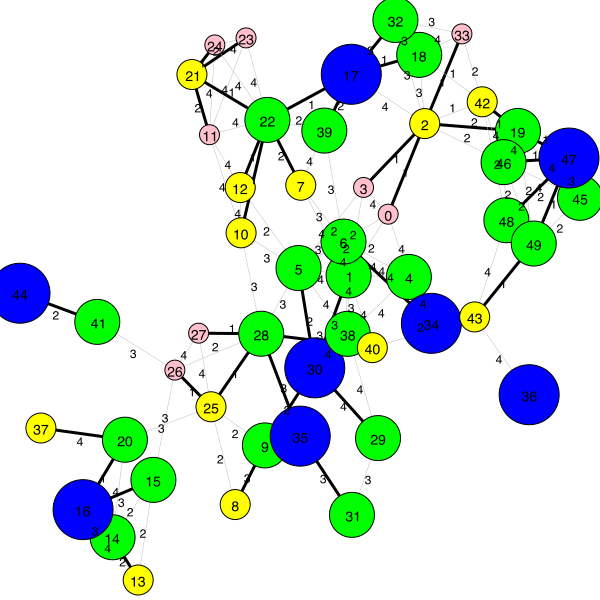

In [1783]:
 #g1.vs[1]1.vs["color"] = "red"
g1.es["color"] = "grey"
g1.es['width'] = 0.5
g1.es['steps'] = ''

for v in Nodes[0]:
    g1.vs[v]["width"] = 60
    g1.vs[v]['color'] = color_set[0]

for v in Nodes[1]:
    g1.vs[v]["width"] = 45
    g1.vs[v]['color'] = color_set[1]

for v in Nodes[2]:
    g1.vs[v]["width"] = 30
    g1.vs[v]['color'] = color_set[2]

for v in Nodes[3]:
    g1.vs[v]["width"] = 20
    g1.vs[v]['color'] = color_set[3]

for e in edges:
    g1.es[g1.get_eid(e[0], e[1])]['width'] = 3
    g1.es[g1.get_eid(e[0], e[1])]['color'] = 'black'


igraph.plot(g1,vertex_label=range(g1.vcount()),edge_label=g1.es['weight'])

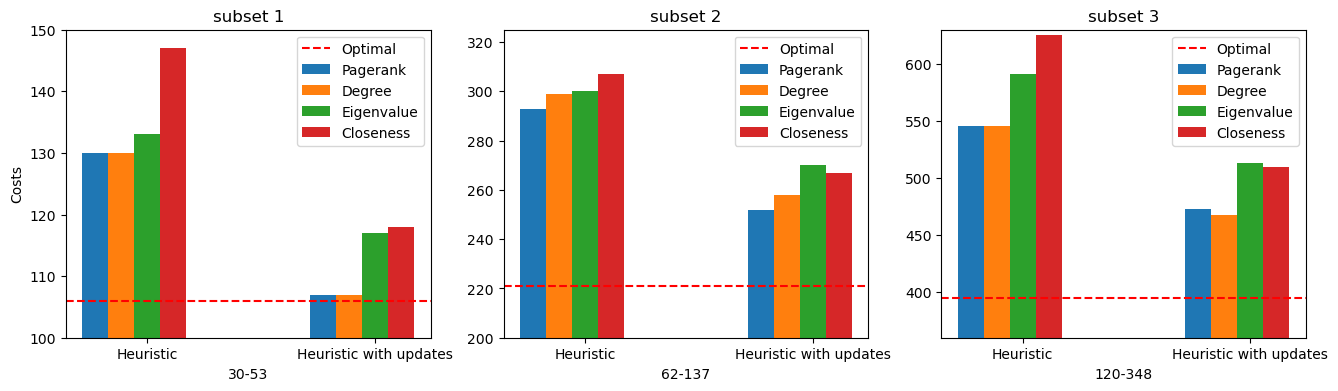

In [1784]:
import matplotlib.pyplot as plt
total_width,n = 0.8,7
width = total_width/n
plt.rcParams['figure.figsize']=(16.0, 4.0)
texture=['//','.','\\']
# name_list = ['500','1000','2000','5000']
# x = list(range(len(name_list)))
name_list = ['Heuristic','Heuristic with updates']
fig, axs = plt.subplots(1,3)

PAGERANK = [130, 107]
DEGREE = [130, 107]
EIGENVALUE = [133, 117]
CLOSENESS = [147, 118]

x = list(range(len(name_list)))
axs[0].bar(x, PAGERANK, width = width, label='Pagerank')

for i in range(len(x)):
    x[i] = x[i] + width
axs[0].bar(x,DEGREE , width = width, label='Degree')

for i in range(len(x)):
    x[i] = x[i] + width
axs[0].bar(x,EIGENVALUE , width = width, tick_label = name_list, label='Eigenvalue')

for i in range(len(x)):
    x[i] = x[i] + width
axs[0].bar(x,CLOSENESS , width = width, label='Closeness')

axs[0].set_title('subset 1')
axs[0].set_xlabel('30-53')
axs[0].set_ylabel('Costs')
axs[0].set_ylim(100, 150)
axs[0].axhline(106, color='red', linestyle='--', label='Optimal')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles + [handles[0]], labels)

PAGERANK = [293, 252]
DEGREE = [299, 258]
EIGENVALUE = [300, 270]
CLOSENESS = [307, 267]

axs[1].bar(x, PAGERANK, width = width, label='Pagerank')

for i in range(len(x)):
    x[i] = x[i] + width
axs[1].bar(x,DEGREE , width = width, label='Degree')

for i in range(len(x)):
    x[i] = x[i] + width
axs[1].bar(x,EIGENVALUE , width = width, tick_label = name_list, label='Eigenvalue')

for i in range(len(x)):
    x[i] = x[i] + width
axs[1].bar(x,CLOSENESS , width = width, label='Closeness')

axs[1].set_title('subset 2')
axs[1].set_xlabel('62-137')
axs[1].set_ylim(200, 325)
axs[1].axhline(221, color='red', linestyle='--', label='Optimal')

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles + [handles[0]], labels)

PAGERANK = [546, 473]
DEGREE = [546, 468]
EIGENVALUE = [591, 513]
CLOSENESS = [625, 510]

x = list(range(len(name_list)))
axs[2].bar(x, PAGERANK, width = width, label='Pagerank')

for i in range(len(x)):
    x[i] = x[i] + width
axs[2].bar(x,DEGREE , width = width, label='Degree')

for i in range(len(x)):
    x[i] = x[i] + width
axs[2].bar(x,EIGENVALUE , width = width, tick_label = name_list, label='Eigenvalue')

for i in range(len(x)):
    x[i] = x[i] + width
axs[2].bar(x,CLOSENESS , width = width, label='Closeness')

axs[2].set_title('subset 3')
axs[2].set_xlabel('120-348')
axs[2].set_ylim(360, 630)
axs[2].axhline(395, color='red', linestyle='--', label='Optimal')

handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles + [handles[0]], labels)
# axs[1].set_xticks([0.3, 0.7])
# axs[1].set_xticklabels(name_list)
plt.savefig('../result/plot.png')
